/tmp/ipykernel_2322456/879109935.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["model"] == "small"]["pmin"] = 0
/tmp/ipykernel_2322456/879109935.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["model"] == "small"]["pmax"] = 0
/tmp/ipykernel_2322456/879109935.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

model                     rejector     p      time            f1 macro  \
                                                  mean       std      mean   
0      RE    DecisionTreeClassifier_10  0.00  0.021359  0.000085  0.673279   
1      RE    DecisionTreeClassifier_10  0.25  0.052048  0.002905  0.693758   
2      RE    DecisionTreeClassifier_10  0.50  0.072874  0.002990  0.743823   
3      RE    DecisionTreeClassifier_10  0.75  0.087068  0.000697  0.765407   
4      RE    DecisionTreeClassifier_10  1.00  0.021329  0.000385  0.770574   
5      RE     DecisionTreeClassifier_2  0.00  0.021290  0.000375  0.673279   
6      RE     DecisionTreeClassifier_2  0.25  0.029512  0.000368  0.673279   
7      RE     DecisionTreeClassifier_2  0.50  0.068619  0.008618  0.729722   
8      RE     DecisionTreeClassifier_2  0.75  0.094069  0.004792  0.768598   
9      RE     DecisionTreeClassifier_2  1.00  0.021147  0.000456  0.770574   
10     RE     DecisionTreeClassifier_5  0.00  0.021319  0.000269  0.673279   
11     RE     DecisionTreeClassifier_5  0.25  0.047037  0.004648  0.677571   
12     RE     DecisionTreeClassifier_5  0.50  0.076645  0.007790  0.749824   
13     RE     DecisionTreeClassifier_5  0.75  0.092073  0.003288  0.765958   
14     RE     DecisionTreeClassifier_5  1.00  0.021532  0.000660  0.770574   
15     RE  DecisionTreeClassifier_None  0.00  0.021192  0.000159  0.673279   
16     RE  DecisionTreeClassifier_None  0.25  0.055664  0.007119  0.700761   
17     RE  DecisionTreeClassifier_None  0.50  0.068179  0.005169  0.731322   
18     RE  DecisionTreeClassifier_None  0.75  0.078149  0.001554  0.758987   
19     RE  DecisionTreeClassifier_None  1.00  0.021411  0.000240  0.770574   
20     RE           LogisticRegression  0.00  0.021114  0.000224  0.673279   
21     RE           LogisticRegression  0.25  0.057251  0.014515  0.687402   
22     RE           LogisticRegression  0.50  0.076816  0.012771  0.733043   
23     RE           LogisticRegression  0.75  0.092661  0.013342  0.761272   
24     RE           LogisticRegression  1.00  0.021053  0.000406  0.770574   
25  REwOC    DecisionTreeClassifier_10  0.00  0.031043  0.000310  0.673279   
26  REwOC    DecisionTreeClassifier_10  0.25  0.046910  0.000443  0.700207   
27  REwOC    DecisionTreeClassifier_10  0.50  0.060892  0.000673  0.723103   
28  REwOC    DecisionTreeClassifier_10  0.75  0.071548  0.000377  0.746892   
29  REwOC    DecisionTreeClassifier_10  1.00  0.084185  0.000056  0.770574   
30  REwOC     DecisionTreeClassifier_2  0.00  0.031034  0.000421  0.673279   
31  REwOC     DecisionTreeClassifier_2  0.25  0.047064  0.000625  0.701044   
32  REwOC     DecisionTreeClassifier_2  0.50  0.062795  0.000669  0.728630   
33  REwOC     DecisionTreeClassifier_2  0.75  0.071830  0.000320  0.750164   
34  REwOC     DecisionTreeClassifier_2  1.00  0.084243  0.000342  0.770574   
35  REwOC     DecisionTreeClassifier_5  0.00  0.031143  0.000522  0.673279   
36  REwOC     DecisionTreeClassifier_5  0.25  0.046926  0.000721  0.701970   
37  REwOC     DecisionTreeClassifier_5  0.50  0.061753  0.001978  0.726590   
38  REwOC     DecisionTreeClassifier_5  0.75  0.071454  0.000712  0.748502   
39  REwOC     DecisionTreeClassifier_5  1.00  0.084224  0.000378  0.770574   
40  REwOC  DecisionTreeClassifier_None  0.00  0.031074  0.000384  0.673279   
41  REwOC  DecisionTreeClassifier_None  0.25  0.047142  0.000531  0.696353   
42  REwOC  DecisionTreeClassifier_None  0.50  0.060639  0.000376  0.721604   
43  REwOC  DecisionTreeClassifier_None  0.75  0.071829  0.000543  0.746229   
44  REwOC  DecisionTreeClassifier_None  1.00  0.084851  0.000239  0.770574   
45  REwOC           LogisticRegression  0.00  0.032885  0.002016  0.673279   
46  REwOC           LogisticRegression  0.25  0.052753  0.003727  0.699453   
47  REwOC           LogisticRegression  0.50  0.070547  0.001250  0.727227   
48  REwOC           LogisticRegression  0.75  0.083004  0.001879  0.752665   
49  REwOC           Logist

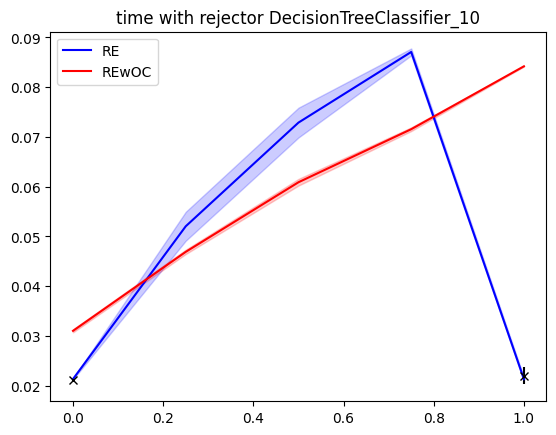

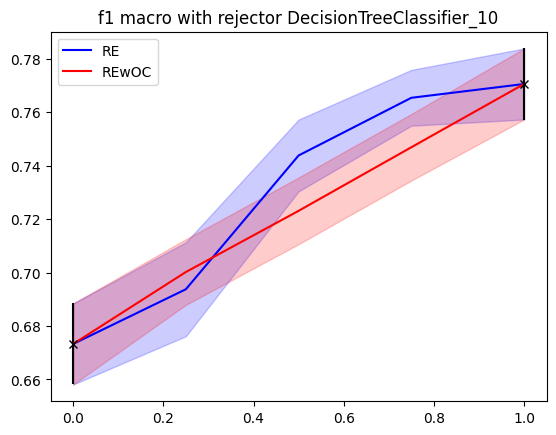

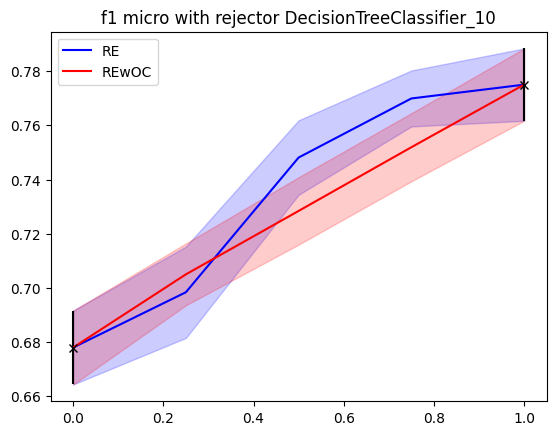

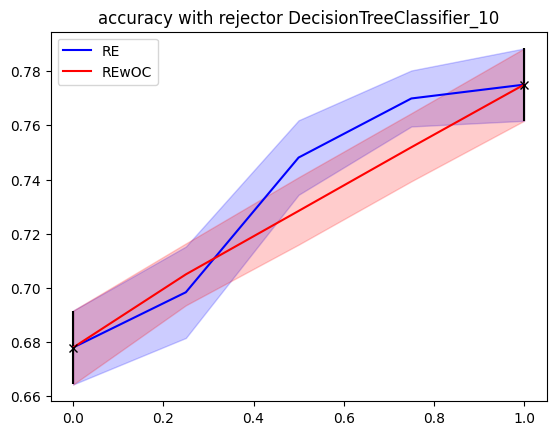

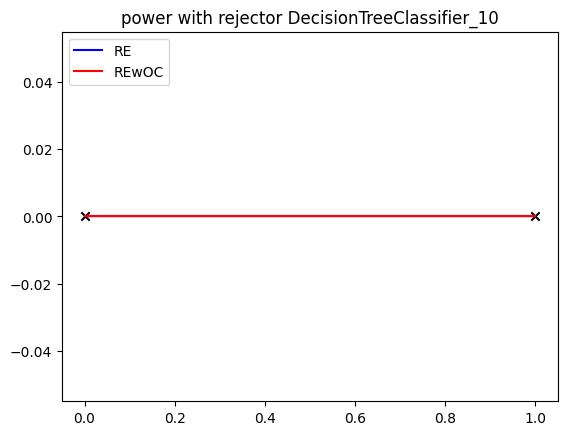

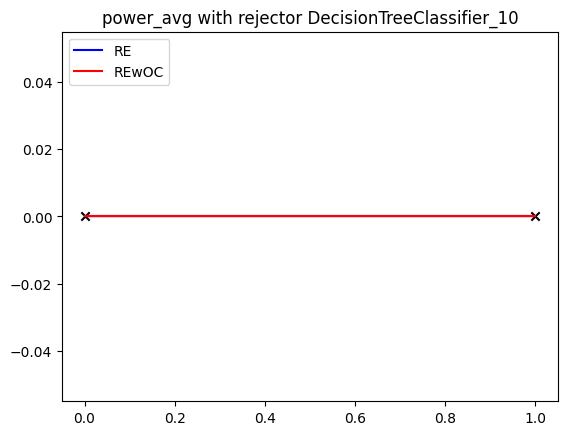

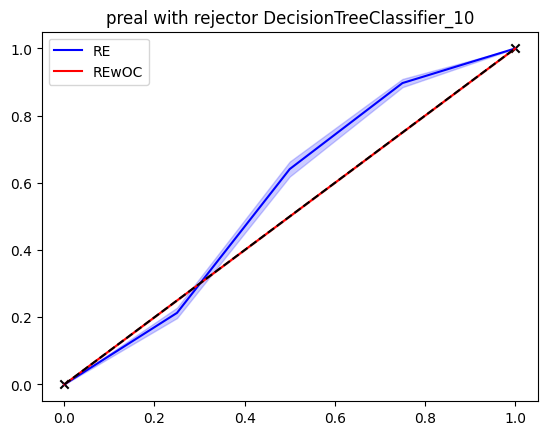

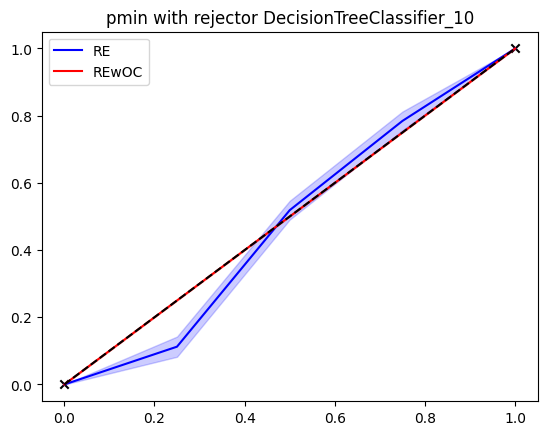

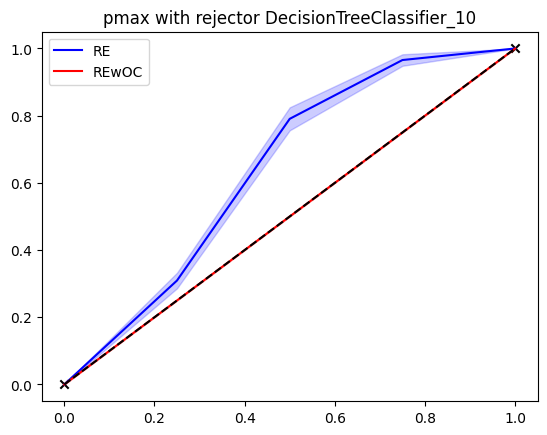

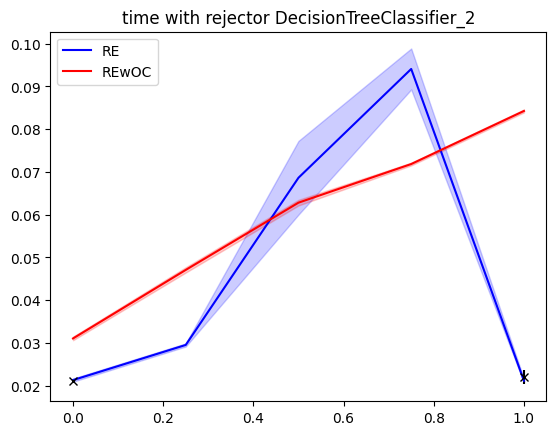

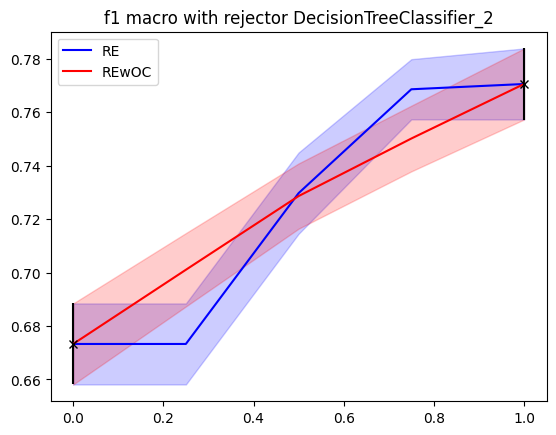

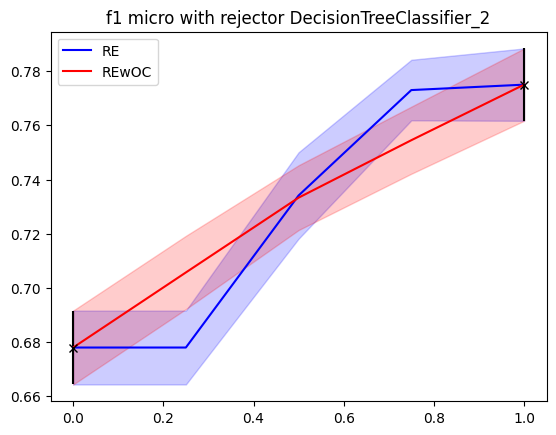

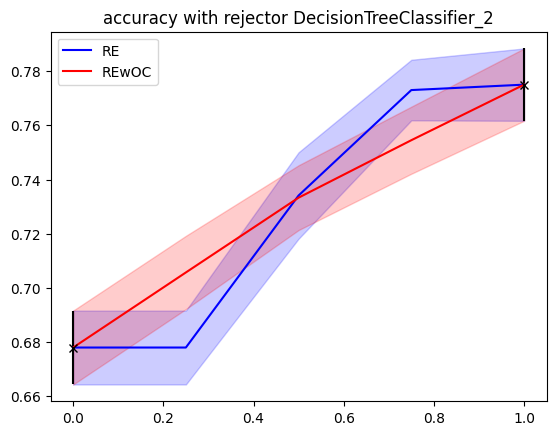

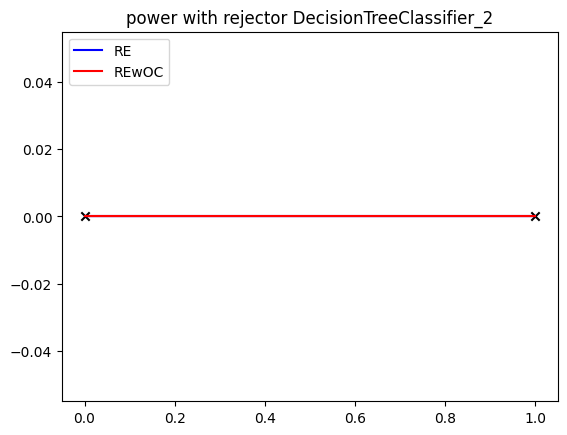

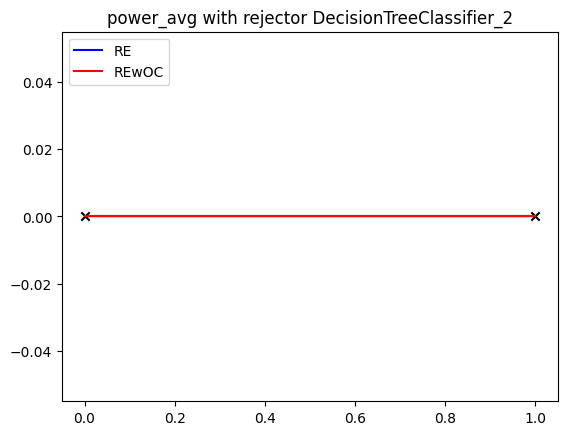

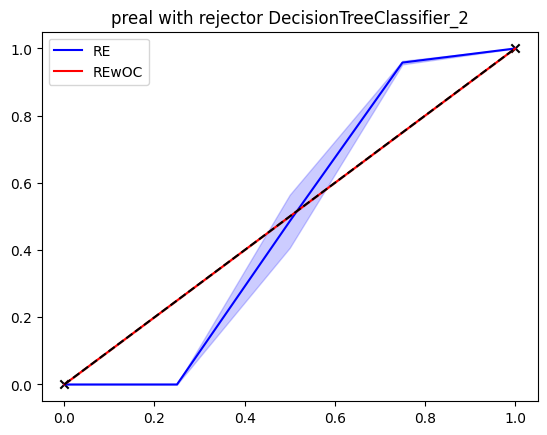

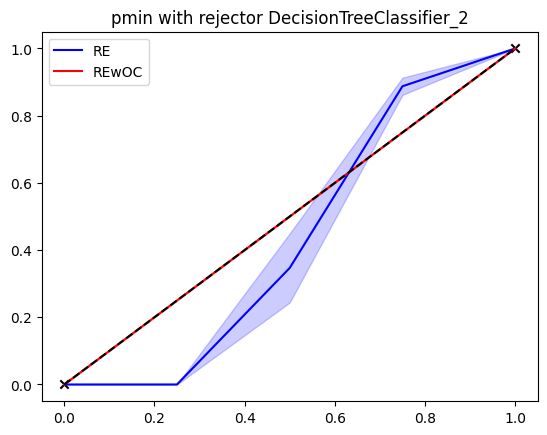

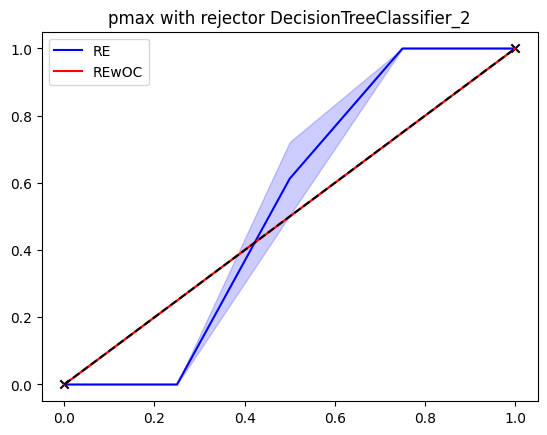

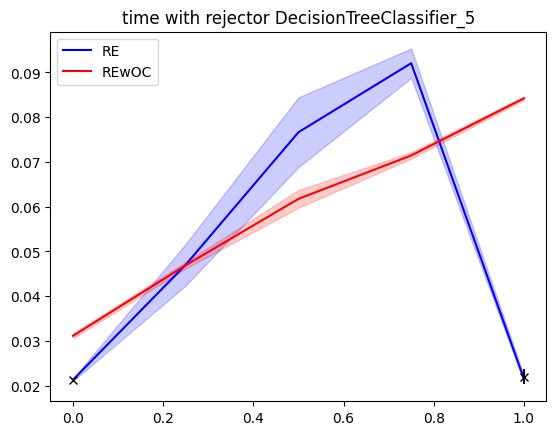

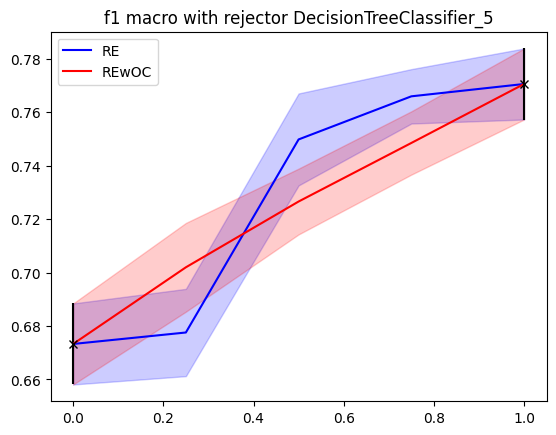

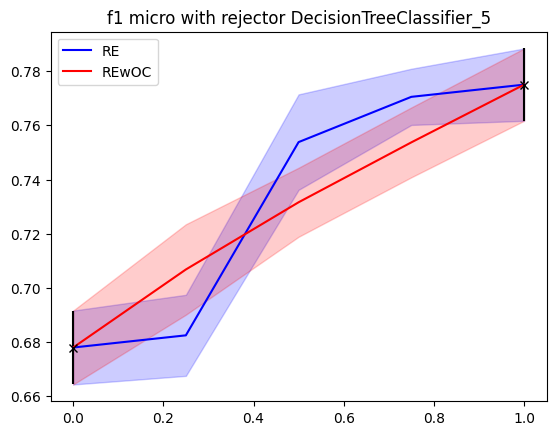

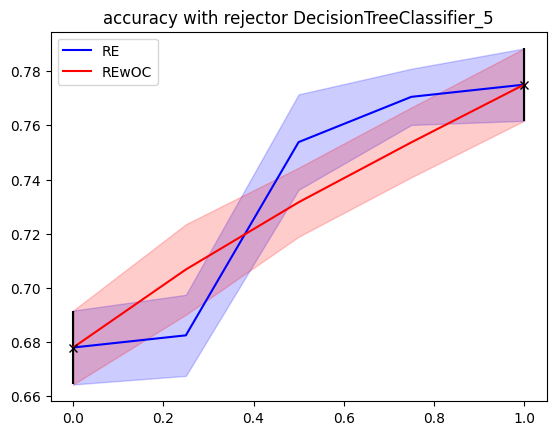

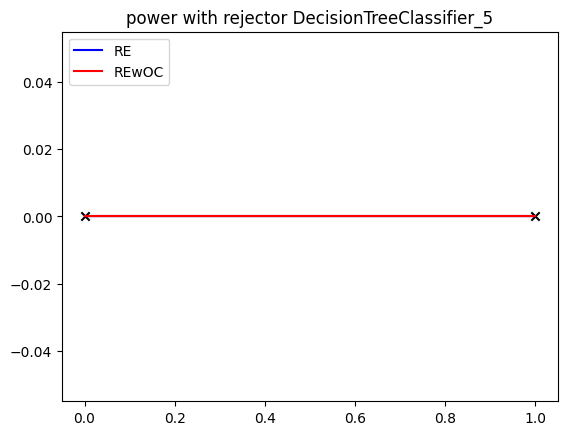

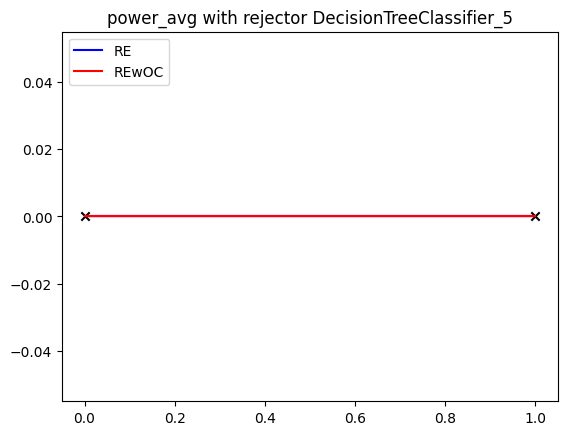

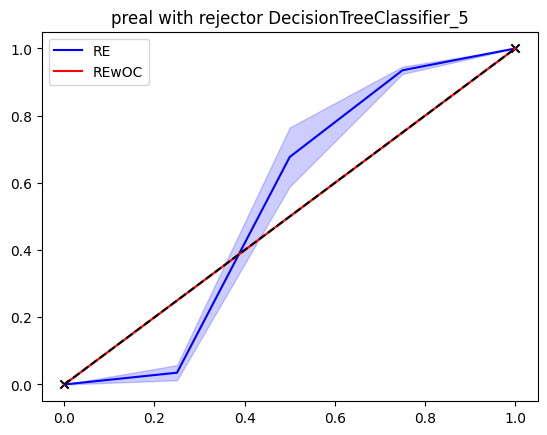

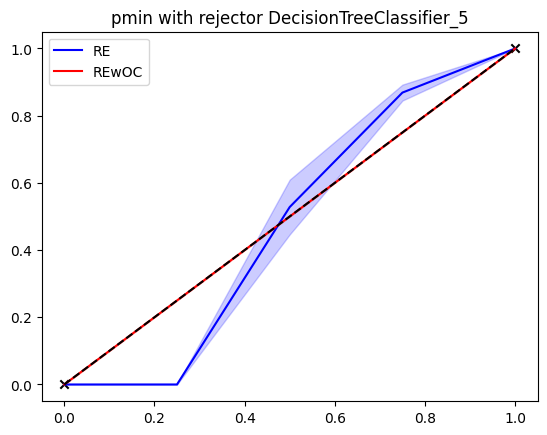

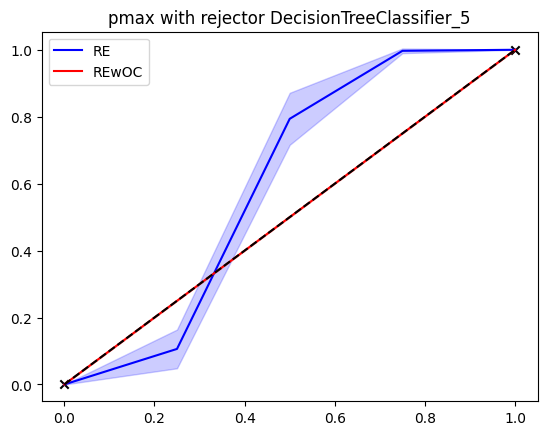

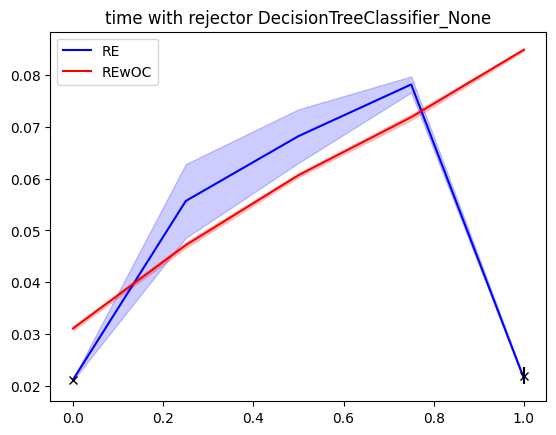

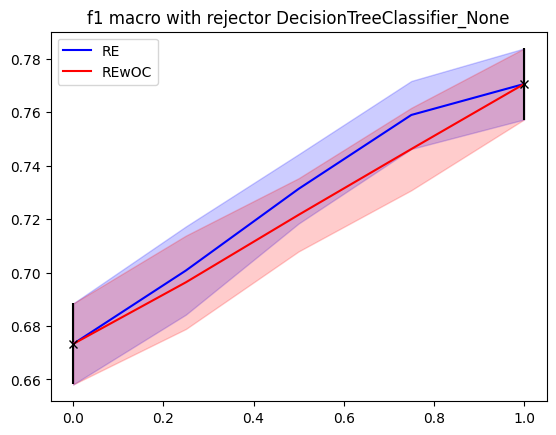

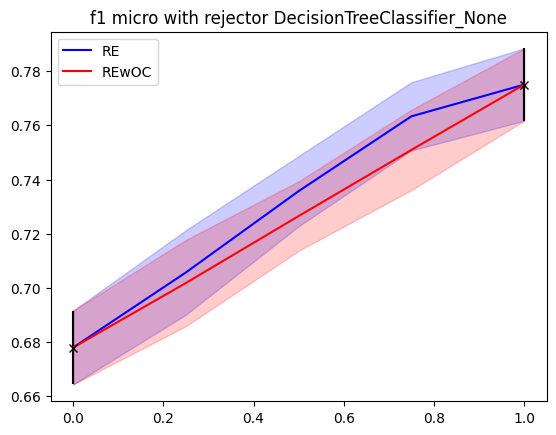

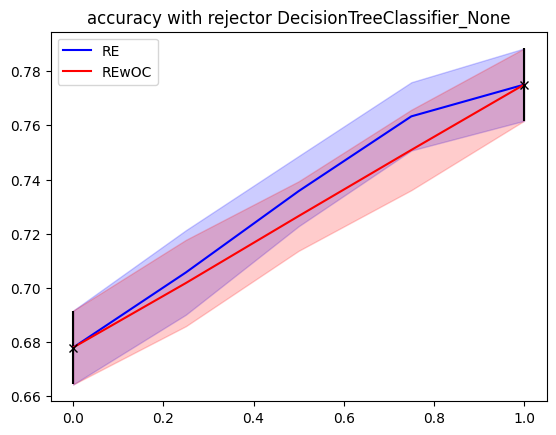

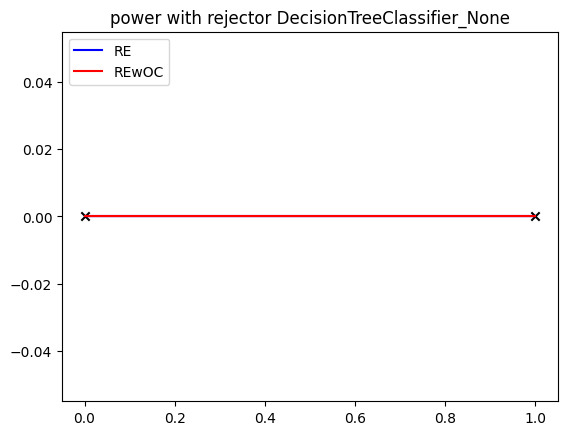

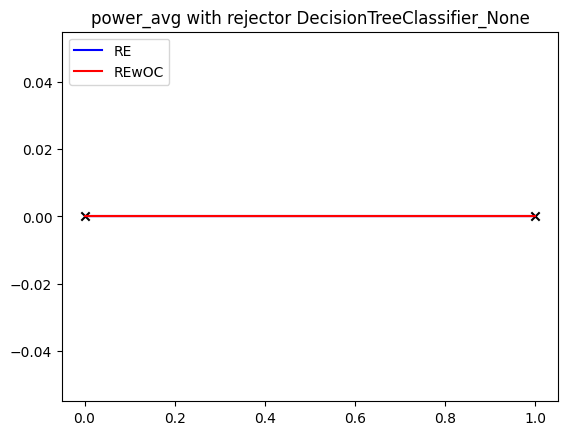

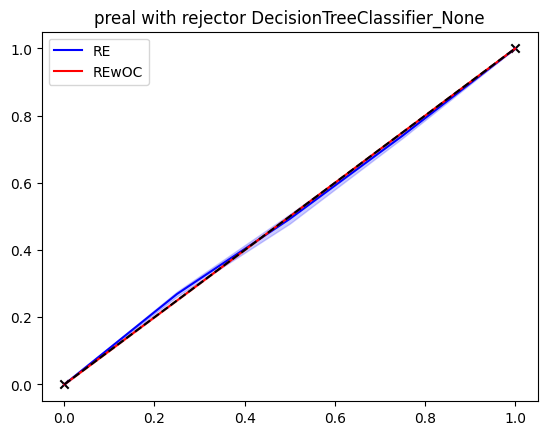

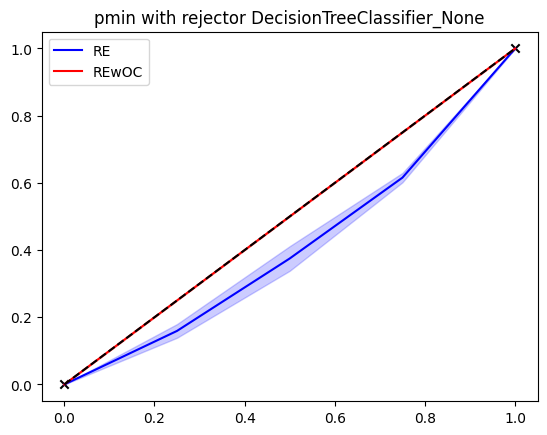

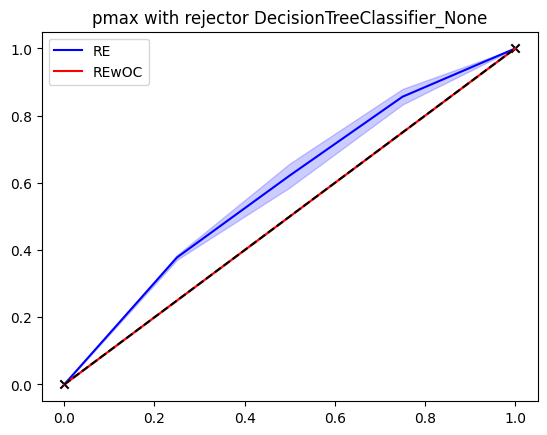

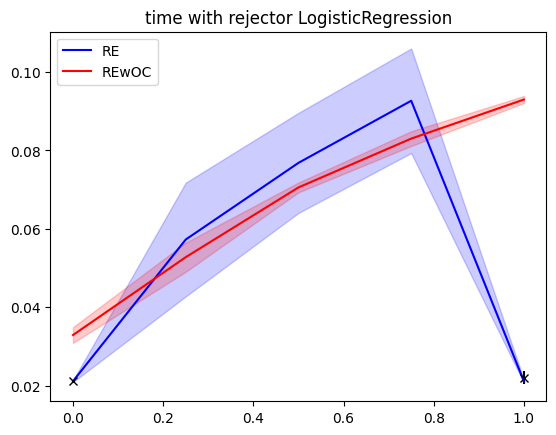

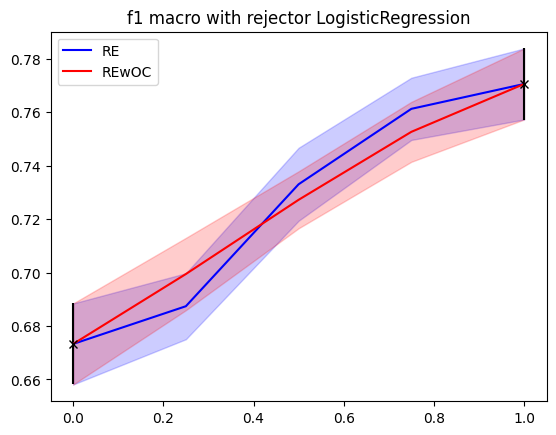

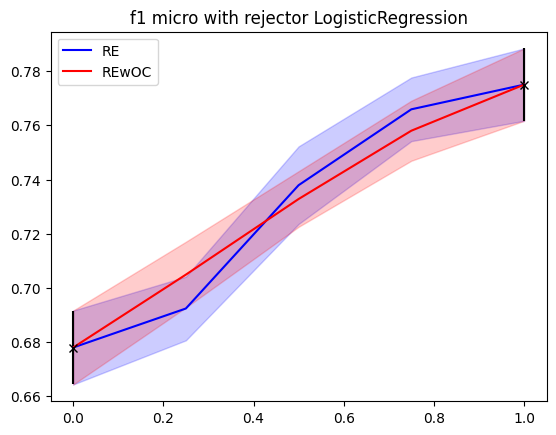

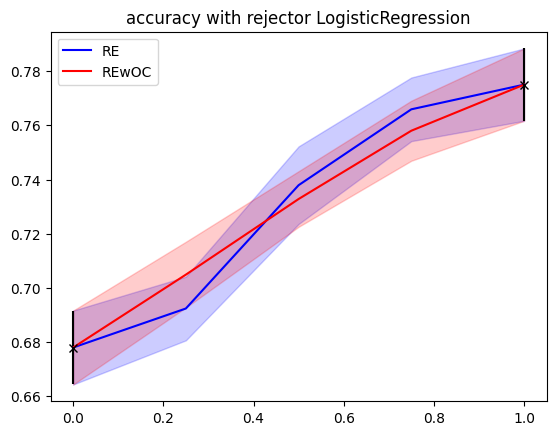

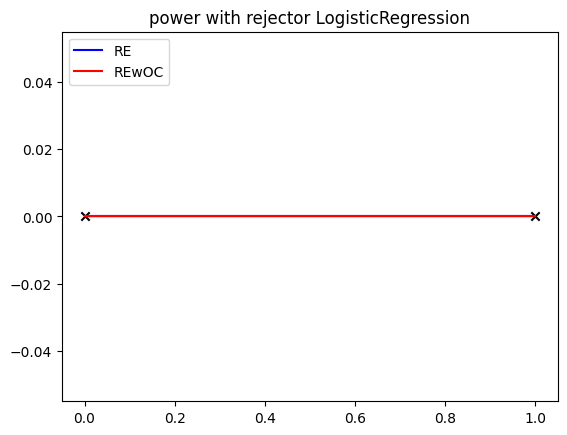

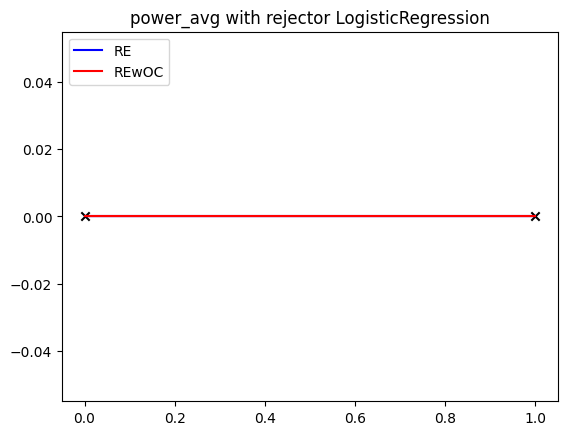

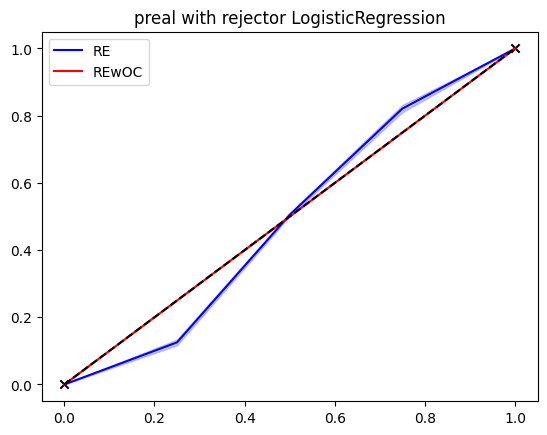

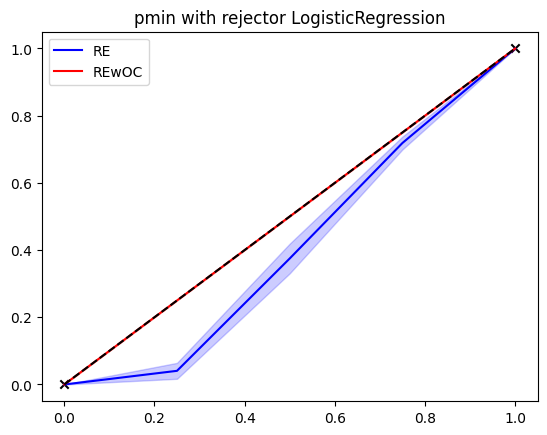

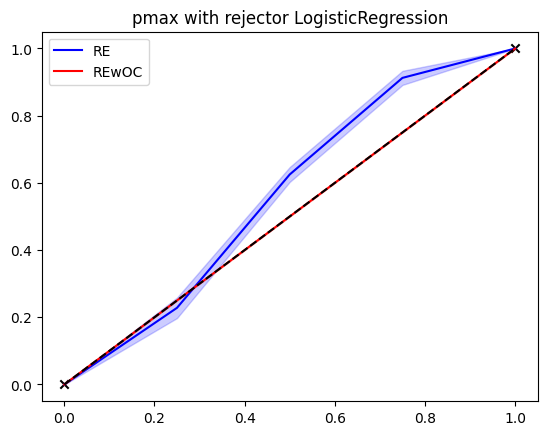

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.patches import PathPatch
from matplotlib.path import Path

def draw_error_band(ax, x, y, err, **kwargs):
    # Calculate normals via centered finite differences (except the first point
    # which uses a forward difference and the last point which uses a backward
    # difference).
    dx = np.concatenate([[x[1] - x[0]], x[2:] - x[:-2], [x[-1] - x[-2]]])
    dy = np.concatenate([[y[1] - y[0]], y[2:] - y[:-2], [y[-1] - y[-2]]])
    l = np.hypot(dx, dy)
    nx = dy / l
    ny = -dx / l

    # end points of errors
    xp = x + nx * err
    yp = y + ny * err
    xn = x - nx * err
    yn = y - ny * err

    vertices = np.block([[xp, xn[::-1]],
                         [yp, yn[::-1]]]).T
    codes = np.full(len(vertices), Path.LINETO)
    codes[0] = codes[len(xp)] = Path.MOVETO
    path = Path(vertices, codes)
    ax.add_patch(PathPatch(path, **kwargs))


df = pd.read_csv("imagenet.csv")
# The small model is always used when p = 0, but CIFARModelWrapper always returns the batch count. For the small model we fix it here with setting preal/pmax/pmin to 0.
df[df["model"] == "small"]["pmin"] = 0
df[df["model"] == "small"]["pmax"] = 0
df[df["model"] == "small"]["preal"] = 0

agg = {
    "time":['mean','std'],
    "f1 macro":['mean','std'],
    "f1 micro":['mean','std'],
    "accuracy":['mean','std'],
    "power":['mean','std'],
    "power_avg":['mean','std'],
    "preal":['mean','std'],
    "pmin":['mean','std'],
    "pmax":['mean','std'],
}

df = df.groupby(["model", "rejector", "p"], dropna=False).agg(agg)
# dff.columns = dff.columns.get_level_values(0)
df.reset_index(inplace=True)
display(df)

# asd
for m in df["rejector"].dropna().unique():
    # if np.isnan(m):
    #     continue

    dff = df[df["rejector"] == m]
    for key in agg.keys():
        ysmall = df[df["model"] == "small"][key]["mean"].values[0]
        ysmall_std = df[df["model"] == "small"][key]["std"].values[0]
        ybig = df[df["model"] == "big"][key]["mean"].values[0]
        ybig_std = df[df["model"] == "big"][key]["std"].values[0]

        plt.title(f"{key} with rejector {m}")
        if ysmall_std > 0 and ybig_std > 0:
            plt.errorbar([0, 1], [ysmall, ybig], yerr = [ysmall_std, ybig_std], c = "k", fmt='x')
        else:
            plt.scatter([0, 1], [ysmall, ybig], c = "k", marker='x')
        plt.plot(dff[dff["model"] == "RE"]["p"], dff[dff["model"] == "RE"][key]["mean"], c = "b", label="RE")
        plt.plot(dff[dff["model"] == "REwOC"]["p"], dff[dff["model"] == "REwOC"][key]["mean"], c = "r", label="REwOC")

        if key == "preal" or key == "pmin" or key == "pmax":
            plt.plot([0,1],[0,1], c="k", linestyle="--")

        plt.fill_between(dff[dff["model"] == "RE"]["p"], dff[dff["model"] == "RE"][key]["mean"] - dff[dff["model"] == "RE"][key]["std"], dff[dff["model"] == "RE"][key]["mean"] + dff[dff["model"] == "RE"][key]["std"],color='blue', alpha=0.2)
        plt.fill_between(dff[dff["model"] == "REwOC"]["p"], dff[dff["model"] == "REwOC"][key]["mean"] - dff[dff["model"] == "REwOC"][key]["std"], dff[dff["model"] == "REwOC"][key]["mean"] + dff[dff["model"] == "REwOC"][key]["std"],color='red', alpha=0.2)
        plt.legend(loc='upper left')
        plt.show()

#dff
#dff[dff["model"] == "RE"]
# dff["time","f1 macro","f1 micro", "accuracy"]
#df.groupby(["model", "p"])["time","f1 macro","f1 micro", "accuracy"].std()

In [34]:
[x for x in df["rejector"].dropna().unique()]

['DecisionTreeClassifier_12', 'DecisionTreeClassifier_4']